In [1]:
import pandas as pd
import time
import numpy as np
import re
import pickle
import string, unicodedata
from unidecode import unidecode
from modulku import praproses as pps
from sklearn.decomposition import PCA

## Load Data

In [2]:
data = pd.read_excel('data/data_komentar_clean_1.xlsx', sheet_name = 'imb_7525') #2500
komentar = data['komentar'].tolist()
label = data['label'].tolist()
kode = data['kode'].tolist()

#data untuk confusion matrix
data_ = pd.read_excel('data/data_komentar_clean_1.xlsx', sheet_name = 'uji_2500') #100
latih_cm = data_['komentar'].tolist()
label_cm = data_['label'].tolist()

latih_cm_ = komentar+latih_cm #2600
label_cm_ = label+label_cm #2600
print(len(komentar))
print(len(latih_cm_))

2500
2600


## Seleksi Fitur

In [3]:
#proses membuat vocabularry
from sklearn.feature_extraction.text import TfidfVectorizer
kosa_kata = set()

###seleksi fitur
kk = TfidfVectorizer()
kk.fit_transform(komentar)
kosa_kata = kk.get_feature_names()
print(len(kosa_kata))
with open('model/feature_imbalance.txt', 'w') as f:
    for item in kosa_kata:
        f.write("%s\n" % item)

9534


## Proses TF-IDF

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
#membuat TF-IDF
f = open("model/feature_imbalance.txt")
kosa_kata = f.read().split()

tfidf = TfidfVectorizer(vocabulary = kosa_kata)
##Membuat Matrix TF-IDF
tfidf_matrix = tfidf.fit_transform(komentar)
X = tfidf_matrix.toarray()
Y = np.array(label)

#For confusion matrix
tfidf_matrix_ = tfidf.fit_transform(latih_cm_) #For CM
print(tfidf_matrix_.shape)
X_ = tfidf_matrix_.toarray()
Y_ = np.array(label_cm_)
y = np.array(kode)

(2600, 9534)


In [17]:
#tfidf.transform(latih_cm).toarray()

## Plot Bar Label Dataset

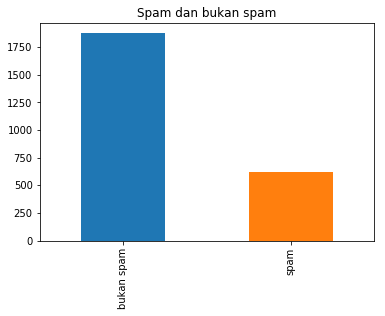

In [5]:

pca = PCA(n_components=2)
#X = pca.fit_transform(X)
pd.value_counts(data['label']).plot.bar(title='Spam dan bukan spam')
#pps.plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')

In [7]:
print(pd.value_counts(data['label']))

bukan spam    1875
spam           625
Name: label, dtype: int64


## Proses Pemodelan

In [8]:
#Import Library
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import GaussianNB

### Input parameter

In [9]:
#parameter CNB
alpha = .9 #0.44

#Parameter SVM
gamma = 0.5
C = 1.8

## K-Fold Cross Validation 

In [44]:
K = 10 #pembagian data uji dan data latih
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score #, precision_score, recall_score
kf= KFold(n_splits=K) 

cSVM = svm.SVC(kernel='rbf', gamma=gamma, C=C)
comNB = ComplementNB(alpha = alpha)
clf = GaussianNB()

akurasi_svm = []
akurasi_cnb = []
akurasi_gnb = []

#for train_index, test_index in kf.split(X_train):
for train_index, test_index in kf.split(X):
    #membagi data latih dan data uji
    X_train, X_test = X[train_index], X[test_index] #pembagian data latih
    y_train, y_test = Y[train_index], Y[test_index]
    
    #Melatih Model 
    mSVM = cSVM.fit(X_train, y_train) #SVM
    mCNB = comNB.fit(X_train, y_train)
    mGNB = clf.fit(X_train, y_train)
            
    #proses prediksi
    P_SVM = mSVM.predict(X_test)
    P_CNB = mCNB.predict(X_test)
    P_GNB = mGNB.predict(X_test)
    
    #menyimpan hasil akurasi tiap iterasi
    akurasi_svm.append(accuracy_score(y_test, P_SVM))
    akurasi_cnb.append(accuracy_score(y_test, P_CNB))
    akurasi_gnb.append(accuracy_score(y_test, P_GNB))
    
rerata_akurasi_svm = sum(akurasi_svm)/len(akurasi_svm)
rerata_akurasi_cnb = sum(akurasi_cnb)/len(akurasi_cnb)
rerata_akurasi_gnb = sum(akurasi_gnb)/len(akurasi_gnb)


print("----------------------------------------")
print("Hasil K-Fold GNB")
print("   akurasi   :",round(rerata_akurasi_gnb,2))
print("----------------------------------------")
print("Hasil K-Fold CNB")
print("   akurasi   :",round(rerata_akurasi_cnb,2))
print("----------------------------------------")
print("Hasil K-Fold SVM")
print("   akurasi   :",round(rerata_akurasi_svm,2))


----------------------------------------
Hasil K-Fold GNB
   akurasi   : 0.86
----------------------------------------
Hasil K-Fold CNB
   akurasi   : 0.93
----------------------------------------
Hasil K-Fold SVM
   akurasi   : 0.94


# Confusion Matrix
## Proses Confusion Matrix untuk SVM

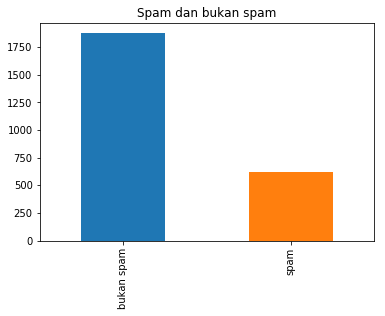

In [9]:
index_train = [x for x in range(2500)]
cm_Y = Y_[index_train]
dc = {"label":cm_Y}
cd = pd.DataFrame(dc, columns=['label'])
pd.value_counts(cd['label']).plot.bar(title='Spam dan bukan spam')

In [10]:
len(index_train)

2500

In [11]:
pd.value_counts(cd['label'])

bukan spam    1875
spam           625
Name: label, dtype: int64

In [12]:
#import itertools
import numpy as np
#import matplotlib.pyplot as plt

from sklearn import svm#, datasets
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


index_train = [x for x in range(2500)]
index__test = [x for x in range(2500, 2600)]

cm_X = X_[index_train]
cm_Y = Y_[index_train]
cm_X_test = X_[index__test]
cm_Y_test = Y_[index__test]

X_train = cm_X
X_test = cm_X_test

y_train = cm_Y
y_test = cm_Y_test

class_names = ['spam', 'bukan spam']

classifier = svm.SVC(kernel='rbf', C=C, gamma=gamma) #Model SVM
y_pred = classifier.fit(X_train, y_train).predict(X_test)
# Compute confusion matrix
print("SVM")
cnf_matrix = confusion_matrix(y_test, y_pred) # inti
print(cnf_matrix)
cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
tp= round(cm [0][0],2)
fn= round(cm [0][1],2)
fp= round(cm [1][0],2)
tn= round(cm [1][1],2)
cm_akurasi = (tp+tn)/(tp+tn+fp+fn)
cm_precision = tp/(tp+fp)
cm_recall = tp/(tp+fn)

f_measure = 2*(cm_precision*cm_recall)/(cm_precision+cm_recall)
print("   F-Measure (SVM)")
print("   ----------------")
print("   akurasi   : ", round(cm_akurasi,2))
print("   precision : ", round(cm_precision,2))
print("   recall    : ", round(cm_recall,2))
print("   f-Measure : ", round(f_measure,2))
print("+"*20)
print("")


classifier = ComplementNB(alpha = alpha)
y_pred = classifier.fit(X_train, y_train).predict(X_test)
# Compute confusion matrix
print("CNB")
cnf_matrix = confusion_matrix(y_test, y_pred) #
print(cnf_matrix)
cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
tp= round(cm [0][0],2)
fn= round(cm [0][1],2)
fp= round(cm [1][0],2)
tn= round(cm [1][1],2)
cm_akurasi = (tp+tn)/(tp+tn+fp+fn)
cm_precision = tp/(tp+fp)
cm_recall = tp/(tp+fn)

f_measure = 2*(cm_precision*cm_recall)/(cm_precision+cm_recall)
print("   F-Measure (CNB)")
print("   ----------------")
print("   akurasi   : ", round(cm_akurasi,2))
print("   precision : ", round(cm_precision,2))
print("   recall    : ", round(cm_recall,2))
print("   f-Measure : ", round(f_measure,2))
print("+"*20)
print("")


classifier = GaussianNB()
y_pred = classifier.fit(X_train, y_train).predict(X_test)
# Compute confusion matrix
print("Naive Bayes")
cnf_matrix = confusion_matrix(y_test, y_pred) # inti
print(cnf_matrix)
cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
tp= round(cm [0][0],2)
fn= round(cm [0][1],2)
fp= round(cm [1][0],2)
tn= round(cm [1][1],2)
cm_akurasi = (tp+tn)/(tp+tn+fp+fn)
cm_precision = tp/(tp+fp)
cm_recall = tp/(tp+fn)

f_measure = 2*(cm_precision*cm_recall)/(cm_precision+cm_recall)
print("   F-Measure Naive Bayes")
print("   ----------------")
print("   akurasi   : ", round(cm_akurasi,2))
print("   precision : ", round(cm_precision,2))
print("   recall    : ", round(cm_recall,2))
print("   f-Measure : ", round(f_measure,2))
print("+"*20)
print("")

SVM
[[50  0]
 [13 37]]
   F-Measure (SVM)
   ----------------
   akurasi   :  0.87
   precision :  0.79
   recall    :  1.0
   f-Measure :  0.88
++++++++++++++++++++

CNB
[[50  0]
 [ 8 42]]
   F-Measure (CNB)
   ----------------
   akurasi   :  0.92
   precision :  0.86
   recall    :  1.0
   f-Measure :  0.93
++++++++++++++++++++

Naive Bayes
[[47  3]
 [ 5 45]]
   F-Measure Naive Bayes
   ----------------
   akurasi   :  0.92
   precision :  0.9
   recall    :  0.94
   f-Measure :  0.92
++++++++++++++++++++



## Menyimpan model

In [10]:
start = time. time()
cSVM = svm.SVC(kernel='rbf', gamma=gamma, C=C)
end = time. time()
comNB = ComplementNB(alpha = alpha)
#Melatih Model untuk data secara keseluruhan (X dan Y)
start = time. time()
cSVM = cSVM.fit(X, Y) #SVN
end = time. time()
print("waktu eksekusi SVM :",round((end - start)/60,3))

start = time. time()
comNB = comNB.fit(X, Y) #CNB
end = time. time()
print("waktu eksekusi CNB :",round((end - start)/60,3))

#save models
filename = 'model\cSVM_imbalance.zulmi'
pickle.dump(cSVM, open(filename, 'wb'))
filename = 'model\comNB_imbalance.zulmi'
pickle.dump(comNB, open(filename, 'wb'))

waktu eksekusi SVM : 2.411
waktu eksekusi CNB : 0.007


In [25]:
#from .utils.extmath import safe_sparse_dot
len(comNB.coef_[0])
#scores = safe_sparse_dot(comNB, self.coef_.T, dense_output=True) + self.intercept_

for i in comNB.coef_[0]:
    print(i)

9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.451755252004451
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.450776670592584
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.47965842173024
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.41435725136537
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.7169993609

9.550001707846118
9.487782283173615
9.50358651640831
9.716999360965985
9.716999360965985
9.405966378586518
9.086653612471592
9.716999360965985
9.716999360965985
8.896822720908627
8.77981826316813
8.646245694615887
9.46244186892102
9.258681679475313
9.443066563393959
9.360831301908428
9.716999360965985
9.591986175581871
9.024430927954091
9.269341756029256
9.334409789441757
9.373042260163627
9.372110657717412
9.456833711884071
9.429516273304326
8.959070499889199
8.806204561493768
9.058833668250005
9.405150438407983
9.465471390476496
9.489626098204376
9.716999360965985
9.716999360965985
9.59282043284401
9.716999360965985
9.348319968279123
9.716999360965985
9.498655643648473
8.723078754679445
7.9968344501794055
8.807495566294733
9.716999360965985
9.374637768514376
9.716999360965985
9.716999360965985
6.6607378836739395
9.716999360965985
9.435786828166025
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.7169993609

9.48553451796382
9.716999360965985
9.496296437364789
9.464067294722682
9.716999360965985
9.716999360965985
7.378168147114819
9.716999360965985
9.716999360965985
9.716999360965985
8.954033481086938
9.36058484180653
9.279963565414285
8.013404327873095
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.263078122704803
9.264918484651718
9.716999360965985
9.142851680764378
8.85016699069091
9.716999360965985
9.716999360965985
9.489626098204376
8.873848371113468
9.299076872864665
9.098043867496532
8.535420236509692
9.407512155935008
9.716999360965985
9.430047182510464
9.302126614128804
9.164702203884161
9.390550801018994
6.436607005958824
9.352168126806161
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
8.899895238685316
9.48841893842001
7.532996954450389
9.34765543222651
9.416618423424854
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.7169993609659

9.44757133379264
8.901850677831002
9.331610778873324
9.716999360965985
9.716999360965985
9.186311998900567
9.716999360965985
9.716999360965985
9.716999360965985
9.386166989013466
9.335367832588842
9.49988114110977
9.449778316122497
9.230177876742628
8.624455413080677
9.392332402518244
9.338445018366057
9.526262651516587
9.537337116137412
8.191963770957232
9.446371948788222
9.472361576268773
8.984379936281927
9.330515205632329
9.716999360965985
9.456817057353682
9.481171295827703
9.457169531046658
8.644813537725412
9.445868833536279
9.343087128914465
9.716999360965985
9.397241848755986
8.843554530554727
9.52617153728959
9.41472012297003
9.494569413437999
9.289512303868321
9.361412113940856
9.716999360965985
9.716999360965985
9.575183823813653
9.716999360965985
9.716999360965985
9.341712242373756
9.716999360965985
9.462174354034593
9.415069041368131
9.413309697547332
9.430857734172708
9.439886778907258
9.411979433657926
9.523190308242883
9.537337116137412
9.414639731158715
9.327834010924

8.99057984656851
8.245691076085524
9.413496205189603
8.945636455163148
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.228211628081356
8.695128370096866
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.416748717267112
9.309093486978565
9.716999360965985
9.716999360965985
9.317151498402598
8.88803047857046
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.382119154975651
9.390997150818883
8.917958792856764
8.87252801847246
9.390369339435825
9.716999360965985
8.51345422167127
9.396415482646534
8.928307908857173
9.394541547056269
9.716999360965985
9.288761428913556
9.21675615378392
8.668081523473044
9.369674682187059
9.17680651615996
9.339488641540415
9.716999360965985
9.716999360965985
9.594259913614705
9.372604644280647
9.716999360965985
9.356597140640094
9.716999360965985
9.062837928437956
9.36058484180653
9.04487449250513


9.716999360965985
9.716999360965985
9.427147477195135
9.38263369803937
9.07767201297015
9.59445278421596
9.716999360965985
9.532330213244972
9.37853890796177
9.414240682373805
8.830263508840266
9.496296437364789
9.716999360965985
9.716999360965985
9.519881977964909
9.716999360965985
9.229444346511887
8.732287911204892
9.141695544870736
9.716999360965985
9.716999360965985
9.48417388230914
9.453520158673083
8.45111036226826
9.3338074727397
9.716999360965985
9.295381769631913
9.481595572069933
9.00602814536345
9.296387851554478
9.716999360965985
9.332310671452111
9.716999360965985
9.298145895805526
9.493790927751803
8.440662060247742
8.325965807417472
9.441822898859114
9.716999360965985
9.461471241550157
9.716999360965985
9.087209673837455
9.313372592081041
9.716999360965985
9.716999360965985
9.395460639853626
9.035109116329858
9.463896940444737
9.716999360965985
9.291798255032017
9.716999360965985
9.716999360965985
9.175515009381332
9.716999360965985
9.513919946014958
9.716999360965985
9

9.716999360965985
9.056112899881231
8.364807301630286
9.405834464754248
9.276589750373384
9.716999360965985
9.561642011669957
9.251300532598705
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
5.761384637539663
9.454932122065964
9.716999360965985
9.299823636449432
9.454932122065964
9.716999360965985
9.38403852986993
9.33551651597292
9.295652593997724
9.455317952720094
9.716999360965985
9.450776670592584
9.357927074890288
9.578960972768783
8.881297092389476
9.27184671794919
9.716999360965985
9.318492660439711
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.359848219492607
9.497673445909605
8.075694927128657
9.716999360965985
9.480636583932053
6.2380273792014735
9.411188463720098
9.45040077435478
9.716999360965985
9.716999360965985
9.716999360965985
9.303389852646903
9.323297590498818
9.424658096497762
7.719146134014753
7.778730348903332
9.415348666846127
9.48063658393

9.482822978262638
9.716999360965985
8.764947962914357
9.361412113940856
9.716999360965985
9.118080658249463
9.442214394084061
9.716999360965985
9.716999360965985
9.39219462732876
9.716999360965985
9.382970276480401
9.716999360965985
9.468756540401678
9.370539078144244
9.51222402534077
9.716999360965985
9.309875273975987
9.716999360965985
9.716999360965985
9.716999360965985
8.576478403909038
9.313354221343266
9.446893905155083
9.336918772007525
8.228462296952268
9.446775235956057
9.716999360965985
9.433101797064968
9.506385972962589
9.443231400899496
9.480863894930282
7.409348507104249
9.716999360965985
8.991597053862932
9.401583586994516
9.216833755979515
9.244288675602535
9.428353896327756
9.299207416561984
9.716999360965985
9.329716236257038
9.716999360965985
9.065593806301218
9.470402184840752
9.15669496350035
9.510336752388227
9.355861231913355
9.716999360965985
9.716999360965985
9.716999360965985
9.460958505565948
8.437390677162067
9.303539903554807
9.716999360965985
9.71699936096

7.362477753232431
9.321798926632669
9.17969892406215
9.415707488687579
9.314320186319385
9.588418033994692
9.328566759938786
9.306568656852543
9.357745879765863
9.716999360965985
9.716999360965985
9.450606297769328
7.751806545339731
9.390997150818883
9.364002550510655
9.716999360965985
9.396335449945687
9.317539395638173
9.381873462047082
9.716999360965985
9.487167910231504
9.38061037969758
9.716999360965985
9.507160122711719
9.716999360965985
9.716999360965985
9.36592920498682
9.231435378992696
9.511913950022926
8.980409107700657
9.197831751669163
9.350514713083596
9.716999360965985
9.443225397917203
9.445928188302426
9.716999360965985
9.014042422122449
9.378098633594538
9.716999360965985
9.443231400899496
8.636213353101654
9.337763182150052
7.0109017591437075
9.308935150930965
9.388830246059973
9.351113679654086
7.4456060282614525
9.396754938146621
9.716999360965985
8.73028058402706
9.716999360965985
9.291951974483004
9.279472447735184
9.35254212405277
9.716999360965985
9.21800724583

9.21844187428841
8.775051340200697
9.275096036521566
9.468296190575868
8.975457789375238
9.472361576268773
9.716999360965985
9.334118919346329
9.553324281409006
9.539469355676365
9.402143254828479
8.85017098699427
9.488723085448116
9.337708777821478
9.617265635528321
9.214526928511647
9.511225354383415
9.219851304992787
9.716999360965985
9.351702389328407
9.324760156308463
9.313841989011259
9.334409789441757
9.47131849432899
9.546145632564372
9.594259913614705
9.716999360965985
9.675620861152202
8.929386918633242
9.588418033994692
9.059491988526835
8.95102945081289
9.236017037446487
9.48625186295046
9.41088645706797
9.508736241677752
9.716999360965985
9.474748626541977
9.50358651640831
9.451798109043636
9.463482014294668
9.433398249218302
9.716999360965985
9.588418033994692
9.458820204880388
9.375745198220152
9.533209403709765
8.934393952352085
9.716999360965985
9.476197057092289
9.716999360965985
9.716999360965985
9.716999360965985
9.513616140126626
9.716999360965985
9.549612003877073

9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.133895077532811
8.872380760002384
9.716999360965985
9.438245539071348
8.245705726853558
9.492705249620942
8.779552205871846
9.329550617259553
9.498898266721328
7.515999765541198
9.390437657841542
9.675620861152202
9.716999360965985
9.716999360965985
9.716999360965985
9.453138326106686
9.350173335077626
9.716999360965985
8.708080382996378
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.097028023630308
9.716999360965985
7.156236050433594
9.716999360965985
9.422321843206278
9.35154532641809
7.745578404363127
9.381420551863103
9.55006281777988
9.716999360965985
9.716999360965985
9.716999360965985
9.521675951747433
9.467747064327009
9.477557428483674
9.135557880580354
9.402138830797119
9.489586983014906
9.5029940574929
9.077545212105838
9.716999360965985
9.3420197245029
9.367670616595664
9.27502021078333
7.462260736514262
9.079383416167317
9.281193916254876
9.716999360965985
9.146431086030898

9.370891376886918
9.561642011669957
9.41862268730064
9.279875725716005
9.474580374069129
9.333309906118195
9.716999360965985
9.51222402534077
9.287502754124464
8.490626038245205
9.716999360965985
9.460804466407321
9.675620861152202
8.7222874755042
9.384209425486896
9.491895875062363
9.411104637756624
9.591986175581871
9.39501389929595
9.440174225609859
9.359537449480136
9.467523766154835
9.716999360965985
9.716999360965985
9.51793616149754
9.51793616149754
9.523685939512761
9.469443924776844
9.41472012297003
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
8.251099198124425
9.392228244953364
9.716999360965985
9.563636127026864
9.716999360965985
9.716999360965985
9.716999360965985
9.533209403709765
9.347382420091884
9.316709761828742
9.716999360965985
9.394972263129814
9.217845710998699
9.371741228699912
9.442214394084061
9.716999360965985
9.436503077220095
9.380928678754197
9.716999360965985
9.291305740058348
9.716999360965985
9.354641479240168


9.716999360965985
7.5305867684491
9.716999360965985
9.230232115115653
8.840338643492457
9.332624029737495
9.404003901705837
9.716999360965985
9.716999360965985
9.716999360965985
9.578098745805072
8.948704763060345
9.431674872637075
8.933866022819556
9.496296437364789
9.716999360965985
9.17739604616899
9.48601220169351
9.290722900726664
9.325307729420045
9.346238321689746
8.879562798076993
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.26081361450085
8.769388160370601
9.19392751577332
9.3433123471968
9.327186568019483
9.499190378396356
9.3750355375008
6.965104476427099
9.473581613299976
9.544420594395472
9.468296190575868
9.349297324852431
9.716999360965985
9.447042789625668
9.08338086943553
9.322972443342705
9.368320382072344
9.511440182730901
9.278199514929753
9.584091080123592
9.186102241330973
9.4058489792434
9.378062207805705
9.716999360965985
9.716999360965985
9.246872083576829
9.716999360965985
9.522361719011752
9.716999360965985
9.357411922373352
9.201

9.54904152351857
9.362172273475764
8.598382867150026
9.343530869449113
9.283219257037528
9.460899935215101
9.716999360965985
8.833803366107546
9.500379749781104
9.521202992940646
9.127969602666777
9.716999360965985
6.457546652146827
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965985
9.312047023382116
9.151721546133897
9.546987885502023
7.254284782219925
9.236446904887671
9.409456669508055
9.50495617251644
9.54904152351857
9.54904152351857
9.352627094382331
9.402399524921528
9.298666714315633
9.323264007949803
6.862786384068405
9.409796353242516
9.446953666026042
9.28010612559409
9.094148557524715
9.675620861152202
9.716999360965985
9.516055250612256
9.390369339435825
9.095956948133564
9.192279845064766
9.312723875564396
9.19728607096348
9.435072052510831
9.716999360965985
9.624509152589612
8.762220747710739
9.386437112917278
9.153755948135158
9.429516273304326
9.391807998960854
9.417742006336404
9.39986687450685
9.14905199533347
9.43893931704581
8

9.716999360965985
9.25667920233083
9.716999360965985
9.38326380243621
9.069221936510965
9.486602634069778
8.340385093656597
9.325702213442305
9.339698352410467
9.05869552617717
9.388830246059973
9.368320382072344
9.519922129188515
9.716999360965985
9.290900273995753
9.305559158575502
9.519495646377655
9.409796353242516
9.716999360965985
9.078896767572218
9.716999360965985
9.716999360965985
9.716999360965985
9.591986175581871
9.330795481400232
9.402393930138425
9.215693670987687
9.563636127026864
9.343301387495721
9.46781921960147
9.716999360965985
9.716999360965985
9.575662606774534
9.716999360965985
9.716999360965985
9.716999360965985
9.716999360965987
9.716999360965985
9.716999360965985
9.34233318370386
9.291951974483004
9.716999360965985
9.716999360965985
9.36124724830696
9.716999360965985
9.716999360965985
9.335815748675104
9.1256605096431
9.325570782537362
9.716999360965985
9.288183506317978
9.15736978729295
9.716999360965985
9.319029565621134
9.716999360965985
9.716999360965985
9

In [24]:
print(" "*9000)

##  komentar baru

In [8]:
from modulku import praproses
#preproses.stemmer_stopWord("atau memakan nasi")

In [10]:
#t_komentar = ["" for x in range (3800)]
#input_komentar = "Cek IG kami Kak, solusiii naiiikkk tinggiiii sampe 175cm, bahkan sampe umuur 33th masih bisa looh, Buruaaaaannn. '"
input_komentar = input("Komentar: ")
#komentar  = [cleaning2(input_komentar)]
komentar0 = praproses.preprocessing(input_komentar)
komentar_ = praproses.removePunc(komentar0)
komentar_ = praproses.stemmer_stopWord(komentar_)
#t_komentar[-1]=komentar_
komentar_ = [komentar_]
print("==============================================================================================================================")
print(komentar0)
print("==============================================================================================================================")

#t_clean_komentar_hapus = komentar_akhir
#komentar_siap = []
#komentar_siap.append(komentar)
#vocabulary = koso_kata
t_tfidf_matrix = tfidf.transform(komentar_)

data_X = t_tfidf_matrix.toarray()
#cek 
#x_cek = data_X[len(t_clean_komentar_hapus)-1:len(t_clean_komentar_hapus)]
#x_cek = data_X[len(t_komentar)-1:len(t_komentar)]
#x_cek = data_X[-1]

# prediksi data asli
P_SVM = cSVM.predict(data_X)
P_NB = comNB.predict(data_X)

# print prediksi
print("Prediksi SVM (TF-IDF)           : ", P_SVM)
print("Prediksi C Naive Bayes (TF-IDF) : ", P_NB)
print(t_tfidf_matrix.shape)


Komentar:  

Prediksi SVM (TF-IDF)           :  ['bukan spam']
Prediksi C Naive Bayes (TF-IDF) :  ['bukan spam']
(1, 9534)


## Prediksi komentar baru lebih dari satu komentar

In [10]:
input_ = pd.read_excel("coba prediksi.xlsx") #memasukkan nama file excel berisi komentar baru (yang akan di cek)


input_list = input_['komentar'].tolist()
#f_komentar = ["" for x in range (3800)]
list_komentar = input_list
join_komentar = praproses.preprocessing_implentasi(list_komentar)# + f_komentar
print("*")
#kokom = join_komentar[:3800]
f = open("model/feature_imbalance.txt") 
voc = f.read().split()
t_tfidf = TfidfVectorizer(vocabulary = voc)
t_tfidf_matrix = tfidf.transform(join_komentar)
#cek_komentar = t_tfidf_matrix[:len(list_komentar)]
cek_komentar = t_tfidf_matrix.toarray()

#melakukan prediksi untuk komentar baru
P_SVM = cSVM.predict(cek_komentar)
P_NB = comNB.predict(cek_komentar)


dict = {'komentar':input_list, "prediksi svm":P_SVM, "prediksi CNB": P_NB}
df = pd.DataFrame(dict, columns=['komentar',"prediksi svm","prediksi CNB"])
df

*


,komentar,prediksi svm,prediksi CNB
0,Assalamualaikum wr.wb..!!!*PROMO BIG SALE 2018...,bukan spam,spam
1,yg msh kangen momen2 asian games bisa klik lin...,bukan spam,spam
2,ok klau begitu saya coba pake panelpediavip.co...,spam,spam
3,Ғollowwww IG @Marcella.beauty_specialist gaaa...,spam,spam
4,Moga lancar n sukses y kak via besuk sore diko...,bukan spam,bukan spam
5,Semingguuu yang laluuuu akuuu cobaaa cekkk ins...,spam,spam
6,THÀNKSSSSSS ÝÀ KÀK ÚDÀHHHHHHHH KÀSÌHHHHHHHH TÀ...,spam,spam
7,MÁŚĶĔŔ ŴÁĴÁĤŃŶÁ oĶĔ ßÁŃĞĔŤ ĶÁĶ ŚĔĶÁŔÁŃĞ ŴÁĴÁĤĶ...,spam,spam
8,"ÀJÀÌBBBBBBBBB ρRÓDÚKNÝÀÀÀÀÀÀ KÀK , BÀNÝÀKKKKK ...",spam,spam


,komentar,prediksi svm,prediksi CNB
0,Assalamualaikum wr.wb..!!!*PROMO BIG SALE 2018...,spam,spam
1,yg msh kangen momen2 asian games bisa klik lin...,spam,spam
2,ok klau begitu saya coba pake panelpediavip.co...,spam,spam
3,Ғollowwww IG @Marcella.beauty_specialist gaaa...,spam,spam
4,Moga lancar n sukses y kak via besuk sore diko...,bukan spam,bukan spam
5,Semingguuu yang laluuuu akuuu cobaaa cekkk ins...,spam,spam
6,THÀNKSSSSSS ÝÀ KÀK ÚDÀHHHHHHHH KÀSÌHHHHHHHH TÀ...,spam,spam
7,MÁŚĶĔŔ ŴÁĴÁĤŃŶÁ oĶĔ ßÁŃĞĔŤ ĶÁĶ ŚĔĶÁŔÁŃĞ ŴÁĴÁĤĶ...,spam,spam
8,"ÀJÀÌBBBBBBBBB ρRÓDÚKNÝÀÀÀÀÀÀ KÀK , BÀNÝÀKKKKK ...",spam,spam
